# Image Generation with Variational Autoencoders

We'll build a variational autoencoder (VAE) to generate images of handwritten digits inspired by the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We've organized these images in two folders named `train` and `test` in the GitHub repository https://github.com/DeepTrackAI/MNIST_dataset:

In [ ]:
!pip install deeptrack
import deeptrack as dt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.8/203.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
import os

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

data_dir = os.path.join("MNIST_dataset", "mnist")

In [ ]:


train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

print(f"{len(train_files)} training images")
print(f"{len(test_files)} test images")

60000 training images
10000 test images


We load the data using `Deeptrack2.0`. We normalize the images in the range `[0, 1]`

In [ ]:
import torch

image_pipeline = (
    dt.LoadImage(files.path)
    >> dt.NormalizeMinMax()
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

We will randomly choose and visualize some of the images in the dataset

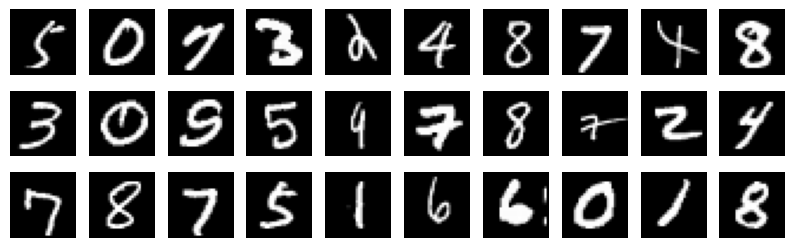

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 10, figsize=((10, 3)))
for ax, train_file in zip(axs.ravel(), np.random.choice(train_files, axs.size)):
    image = image_pipeline(train_file)
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_axis_off()

In [ ]:
print(image_pipeline(train_files).min(),image_pipeline(train_files).max())

tensor(0.) tensor(1.)


In [ ]:
train_files

## Variational autoencoder
We define the autoencoder architecture with a bidimensional latent space.

In [ ]:
!pip install  deeplay
import deeplay as dl
from torch.nn import BCELoss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 326.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:


vae = dl.VariationalAutoEncoder(
    channels=[32, 64],
    latent_dim=2,
    reconstruction_loss=BCELoss(reduction="sum"),
    beta=1,
).create()
print(vae)

#list(vae.parameters())
#vae.state_dict()
#optimizer=torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Identity()
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): PoolLayerActivationNormalization(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
        (normalization): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_f

We define the datasets, the dataloader and the trainer. We train the autoencder for `100` epochs.

In [ ]:
from torchsummary import summary
!pip install torchsummary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vae = vae.to(device)
summary(vae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Identity-1            [-1, 1, 28, 28]               0
            Conv2d-2           [-1, 32, 28, 28]             320
              ReLU-3           [-1, 32, 28, 28]               0
          Identity-4           [-1, 32, 28, 28]               0
PoolLayerActivationNormalization-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          18,496
              ReLU-8           [-1, 64, 14, 14]               0
          Identity-9           [-1, 64, 14, 14]               0
PoolLayerActivationNormalization-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
             ReLU-13             [-1, 64, 7, 7]               0
         I

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(42)

train_dataset = dt.pytorch.Dataset(image_pipeline & image_pipeline, inputs=train_files)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vae_trainer = dl.Trainer(max_epochs=1, accelerator="auto")
vae_trainer.fit(vae, train_loader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params
---------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K
1 | fc_mu               | Linear                 | 6.3 K 
2 | fc_var              | Linear                 | 6.3 K 
3 | fc_dec              | Linear                 | 9.4 K 
4 | decoder             | ConvolutionalDecoder2d | 76.3 K
5 | reconstruction_loss | BCELoss                | 0     
6 | train_metrics       | MetricCollection       | 0     
7 | val_metrics         | MetricCollection       | 0     
8 | test_metrics        | MetricCollection       | 0     
9 | optimizer           | Adam                   | 0     
---------------------------------------------------------------
153 K     Trainable params
0         Non-trainabl

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(42)
configurations = [
    #{"channels": [64, 128], "latent_dim": 8, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1.5},
    #{"channels": [16, 64], "latent_dim": 4, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1},
    #{"channels": [24, 48], "latent_dim": 4, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1},
    #{"channels": [64, 128], "latent_dim": 4, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1},
    #{"channels": [64, 128], "latent_dim": 2, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1},
    #{"channels": [64, 128], "latent_dim": 2, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1.5},
    {"channels": [64, 128], "latent_dim": 4, "reconstruction_loss": BCELoss(reduction="sum"), "beta": 1.5}
]

for config in configurations:
    vae = dl.VariationalAutoEncoder(**config).create()
    print(vae)
    train_dataset = dt.pytorch.Dataset(image_pipeline & image_pipeline, inputs=train_files)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    vae_trainer = dl.Trainer(max_epochs=100, accelerator="auto")
    vae_trainer.fit(vae, train_loader)

NameError: name 'torch' is not defined

## Image Generation
We generate images by sampling a continuous distribution of latent representations and reconstructing the images using the trained VAE’s decoder.

In [ ]:
from torch.distributions.normal import Normal

img_num, img_size = 21, 28

z0_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))
z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))

for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
        z = torch.stack((z0, z1)).unsqueeze(0)
        generated_image = vae.decode(z).clone().detach()
        image[
            i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size,
        ] = generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z0_grid.numpy(), 1),
)
plt.yticks(
    np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
    np.round(z1_grid.numpy(), 1),
)
plt.xlabel("z0", fontsize=20)
plt.ylabel("z1", fontsize=20)
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x2352)

## Clustering in the latent space
We will use the VAE as a clustering algorithm, i.e., to cluster the input images into different classes with respect to the latent space encoding.

We define a pipeline to get images and labels of the test dataset.

In [ ]:
label_pipeline = dt.Value(files.label_name[0]) >> int

In [ ]:
test_dataset = dt.pytorch.Dataset(image_pipeline & label_pipeline, inputs=test_files)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We encode the images of the test dataset into latent space representation.

In [ ]:
mu_list, test_labels = [], []  ### Carlo: changed z back to mu
for image, label in test_loader:
    mu, _ = vae.encode(image)
    mu_list.append(mu)
    test_labels.append(label)
mu_tensor = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

We plot the latent-space representation, color coded according to the image label.

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(mu_tensor[:, 0], mu_tensor[:, 1], s=3, c=test_labels, cmap="tab10")
plt.xlabel("mu_tensor[:, 0]")
plt.ylabel("mu_tensor[:, 1]")
plt.colorbar()
plt.gca().invert_yaxis()  ### Carlo: this is important to keep the same order as the plot above
plt.axis("equal")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.show()

## Save model

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_vae.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=vae.state_dict(),
           f=MODEL_SAVE_PATH)



In [ ]:
loaded_01_vae = dl.VariationalAutoEncoder(
    channels=[32, 64],
    latent_dim=2,
    reconstruction_loss=BCELoss(reduction="sum"),
    beta=1,
).create()

loaded_01_vae.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [ ]:
loaded_01_vae .state_dict()
